# Zoopla ETL Pipeline (Python + Pandas)

## Load Libraries & Dependencies

In [42]:
import os
import requests
import pandas as pd
import ast
from time import sleep
import json
import psycopg2
from psycopg2 import sql
from dotenv import load_dotenv
load_dotenv()
from IPython.display import Image, display
from sqlalchemy import Column, Integer, String, Float, Boolean, ForeignKey, create_engine
from sqlalchemy.orm import declarative_base, sessionmaker


## Extraction Layer — Pull Data from API

In [43]:
load_dotenv()

base_url = "https://zoopla.p.rapidapi.com/properties/v2/list"

headers = {
    "x-rapidapi-key": os.getenv("x-rapidapi-key"),
    "x-rapidapi-host": os.getenv("x-rapidapi-host")
}

querystring = {
    "locationValue": "Edinburgh",
    "category": "residential",
    "bedsMin": "1",
    "bedsMax": "3",
    "furnishedState":"Any",
    "includeRented":"true",
    "includeRetirementHomes":"true",
    "includeSharedAccommodation":"true",
    "includeSharedOwnership":"true",
    "includeSold":"true",
    "sortOrder": "newest_listings"
}

all_data = []

for page in range(1, 61):  
    querystring["page_number"] = page
    response = requests.get(base_url, headers=headers, params=querystring)
    if response.status_code == 200:
        json_response = response.json()

        listings = json_response.get('data', {}).get('listings', {}).get('regular', [])
        #print(f"Page {page}: Retrieved {len(listings)} listings")

        all_data.extend(listings)
    else:
        print(f"Page {page} failed: {response.status_code}")
    sleep(1)

df = pd.json_normalize(all_data)
df

,address,flag,highlights,imageUris,isExpired,isFeatured,isPremium,listingId,shortPriceTitle,publicationStatus,...,agent.isDeveloper,attributes.bedrooms,attributes.bathrooms,attributes.livingRooms,location.coordinates.latitude,location.coordinates.longitude,pricing.value,pricing.qualifier,pricing.qualifierLabel,pricing.label
0,"261, Calder Road, Edinburgh EH114Rh EH11",Just added,[],[https://lid.zoocdn.com/645/430/64795480cc961a...,False,False,False,69079717,£115k,Live,...,False,2,0,0,55.924777,-3.275563,115000,guide_price,Guide price,"£115,000"
1,"2/12, Westfield Court, Edinburgh EH112Rj EH11",Just added,[],[https://lid.zoocdn.com/645/430/76c99556c3b89e...,False,False,False,69465827,£170k,Live,...,False,3,0,0,55.936696,-3.242641,170000,guide_price,Guide price,"£170,000"
2,"Tower Street, Edinburgh EH6",Just added,[],[https://lid.zoocdn.com/645/430/62495e22f05b52...,False,False,False,70402149,£250k,Live,...,False,2,2,1,55.977168,-3.166650,250000,offers_over,Offers over,"£250,000"
3,"Rutland Square, New Town, Edinburgh EH1",Just added,[],[https://lid.zoocdn.com/645/430/fdc7835af0b112...,False,False,False,70401726,£525k,Live,...,False,1,2,1,55.948917,-3.209580,525000,offers_over,Offers over,"£525,000"
4,"St. Katharine's Brae, Edinburgh EH16",Just added,[],[https://lid.zoocdn.com/645/430/24c78208064848...,False,False,False,70399419,£149k,Live,...,False,1,1,1,55.905469,-3.164222,149000,offers_over,Offers over,"£149,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,"Constitution Street, Edinburgh EH6",Just added,[],[https://lid.zoocdn.com/645/430/b0b2de9e3c7ab3...,False,False,False,70385276,£395k,Live,...,False,2,2,1,55.972480,-3.169650,395000,offers_over,Offers over,"£395,000"
1496,"Gorgie Road, Edinburgh EH11",Just added,[],[https://lid.zoocdn.com/645/430/6d8b3980149ece...,False,False,False,70383635,£285k,Live,...,False,2,2,1,55.931615,-3.251619,285000,offers_over,Offers over,"£285,000"
1497,"Barnton Gardens, Edinburgh, Scotland EH4",Just added,[],[https://lid.zoocdn.com/645/430/b00f705bf6b9ea...,False,False,False,70382904,£900k,Live,...,False,3,3,3,55.970823,-3.282423,900000,offers_over,Offers over,"£900,000"
1498,"Easter Dalry Rigg, Edinburgh, Midlothian EH11",Just added,[],[https://lid.zoocdn.com/645/430/b968f8005e3486...,False,False,False,70382546,£295k,Live,...,False,3,2,1,55.943454,-3.222826,295000,offers_over,Offers over,"£295,000"


In [ ]:
df.to_csv("zoopla.csv")

## Transformation Layer — Clean & Normalize Data

- We'll aim for a 3NF-style structure with dimension and fact tables.

**Normalization Objective**: split into a star schema:

- 1. dim_property : Static attributes about the property type
- 2. dim_location : Lat/lon, address info
- 3. dim_agent : Agent name and contact
- 4. fact_property_listing : Transactional and status fields

In [2]:
df = pd.read_csv("zoopla.csv")
df.info()
#df_all.to_csv("zoopla_edinburgh_listings.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1500 non-null   int64  
 1   address                         1500 non-null   object 
 2   flag                            1500 non-null   object 
 3   highlights                      1500 non-null   object 
 4   imageUris                       1500 non-null   object 
 5   isExpired                       1500 non-null   bool   
 6   isFeatured                      1500 non-null   bool   
 7   isPremium                       1500 non-null   bool   
 8   listingId                       1500 non-null   int64  
 9   shortPriceTitle                 1500 non-null   object 
 10  publicationStatus               1500 non-null   object 
 11  tags                            1500 non-null   object 
 12  title                           15

In [3]:
# Normalize column names: --- Rename columns to snake_case ---
df_clean = df.copy()
df_clean.columns = df_clean.columns.str.replace(r"[^\w]+", "_", regex=True).str.lower()
df_clean


,unnamed_0,address,flag,highlights,imageuris,isexpired,isfeatured,ispremium,listingid,shortpricetitle,...,agent_isdeveloper,attributes_bedrooms,attributes_bathrooms,attributes_livingrooms,location_coordinates_latitude,location_coordinates_longitude,pricing_value,pricing_qualifier,pricing_qualifierlabel,pricing_label
0,0,"2/15 Magdalene Avenue, Edinburgh, Midlothian EH15",Just added,[],['https://lid.zoocdn.com/645/430/feadc7309e037...,False,False,False,70327275,£125k,...,False,2,1,0,55.942650,-3.111833,125000,guide_price,Guide price,"£125,000"
1,1,"Queensferry Road, Edinburgh EH4",Just added,[],['https://lid.zoocdn.com/645/430/789c6e7a472e5...,False,False,False,70325772,£275k,...,False,3,1,1,55.957121,-3.248293,275000,offers_over,Offers over,"£275,000"
2,2,"Fowler Terrace, Polwarth, Edinburgh EH11",Just added,[],['https://lid.zoocdn.com/645/430/ebe038c6210c1...,False,False,False,70325397,£160k,...,False,1,1,1,55.939579,-3.219951,160000,offers_over,Offers over,"£160,000"
3,3,"1/9 New Assembly Close, 142 High Street, Edinb...",Just added,[],['https://lid.zoocdn.com/645/430/ed9e236588c8e...,False,False,False,70325179,£230k,...,False,1,1,1,55.949866,-3.188669,230000,offers_over,Offers over,"£230,000"
4,4,"Bughtlin Drive, Edinburgh EH12",Just added,[],['https://lid.zoocdn.com/645/430/9b6c000aff69b...,False,False,False,70325063,£280k,...,False,3,1,2,55.952287,-3.309618,279995,fixed_price,Fixed price,"£279,995"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1495,"Gorgie Road, Gorgie, Edinburgh EH11",Just added,[],['https://lid.zoocdn.com/645/430/de5dc45dd5010...,False,False,False,70316928,£150k,...,False,1,1,1,55.938542,-3.230565,150000,offers_over,Offers over,"£150,000"
1496,1496,"Mountcastle Crescent, Edinburgh EH8",Just added,[],['https://lid.zoocdn.com/645/430/9dae5a5fb6447...,False,False,False,70316929,£340k,...,False,3,1,1,55.952832,-3.128937,340000,offers_over,Offers over,"£340,000"
1497,1497,"38-1 Restalrig Road, Edinburgh EH6",Just added,[],['https://lid.zoocdn.com/645/430/240699fd351f1...,False,False,False,70316772,£220k,...,False,2,1,1,55.969143,-3.159597,220000,offers_over,Offers over,"£220,000"
1498,1498,"Pattison Street, Edinburgh EH6",Just added,[],['https://lid.zoocdn.com/645/430/07d3e8450758e...,False,False,False,70316756,£215k,...,False,2,1,1,55.973669,-3.163119,215000,offers_over,Offers over,"£215,000"


### --- Clean columns ---

In [4]:
# Remove unwanted columns
df_clean = df_clean.drop(columns=["pricing_qualifierlabel", "pricing_label", "agent_logouri"])

In [23]:
# handle missing values
df_clean = df_clean.fillna({
    "pricing_qualifier": "Unknown"
})

In [5]:
# Remove currency symbols from shortpricetitle
df_clean["shortpricetitle"] = df_clean["shortpricetitle"].str.replace(r"[^\d.]", "", regex=True).astype(float)

In [6]:
# Keep only suffix of attribute columns
attribute_cols = ["attributes_bedrooms", "attributes_bathrooms", "attributes_livingrooms"]
attribute_cols_cleaned = [col.split("_")[-1] for col in attribute_cols]
df_clean.rename(columns=dict(zip(attribute_cols, attribute_cols_cleaned)), inplace=True)

In [7]:
# Retain only lat/lon columns
df_clean = df_clean.rename(columns={"location_coordinates_latitude": "latitude", "location_coordinates_longitude": "longitude"})

In [8]:
# --- Normalize address into address, city, postcode ---
def parse_address_parts(address):
    """
    Safely extract address_line, city, and postcode from an address string.
    Handles edge cases where fewer commas are present.
    """
    try:
        parts = [part.strip() for part in address.strip().split(',')]
        if len(parts) >= 3:
            postcode = parts[-1].split()[-1]
            city = parts[-2]
            address_line = ", ".join(parts[:-2])
        elif len(parts) == 2:
            postcode = parts[-1].split()[-1]
            city = parts[-1].rsplit(' ', 1)[0]
            address_line = parts[0]
        else:
            address_line = address
            city = ""
            postcode = ""
    except Exception:
        address_line, city, postcode = address, "", ""
    return pd.Series([address_line, city, postcode])

# Apply to DataFrame
df_clean[["address_line", "city", "postcode"]] = df_clean["address"].apply(parse_address_parts)



In [9]:
# Convert tags and highlights (list of dicts) to comma-separated strings of label values

def extract_label_list(cell):
    """Convert a stringified list of dicts into comma-separated labels."""
    if isinstance(cell, str) and cell.strip().startswith("["):
        try:
            parsed = ast.literal_eval(cell)
            if isinstance(parsed, list):
                return ", ".join(d.get("label", "") for d in parsed if isinstance(d, dict))
        except (ValueError, SyntaxError):
            pass
    return ""

df_clean["tags"] = df_clean["tags"].apply(extract_label_list)
df_clean["highlights"] = df_clean["highlights"].apply(extract_label_list)
df_clean

,unnamed_0,address,flag,highlights,imageuris,isexpired,isfeatured,ispremium,listingid,shortpricetitle,...,bedrooms,bathrooms,livingrooms,latitude,longitude,pricing_value,pricing_qualifier,address_line,city,postcode
0,0,"2/15 Magdalene Avenue, Edinburgh, Midlothian EH15",Just added,,['https://lid.zoocdn.com/645/430/feadc7309e037...,False,False,False,70327275,125.0,...,2,1,0,55.942650,-3.111833,125000,guide_price,2/15 Magdalene Avenue,Edinburgh,EH15
1,1,"Queensferry Road, Edinburgh EH4",Just added,,['https://lid.zoocdn.com/645/430/789c6e7a472e5...,False,False,False,70325772,275.0,...,3,1,1,55.957121,-3.248293,275000,offers_over,Queensferry Road,Edinburgh,EH4
2,2,"Fowler Terrace, Polwarth, Edinburgh EH11",Just added,,['https://lid.zoocdn.com/645/430/ebe038c6210c1...,False,False,False,70325397,160.0,...,1,1,1,55.939579,-3.219951,160000,offers_over,Fowler Terrace,Polwarth,EH11
3,3,"1/9 New Assembly Close, 142 High Street, Edinb...",Just added,,['https://lid.zoocdn.com/645/430/ed9e236588c8e...,False,False,False,70325179,230.0,...,1,1,1,55.949866,-3.188669,230000,offers_over,1/9 New Assembly Close,142 High Street,EH1
4,4,"Bughtlin Drive, Edinburgh EH12",Just added,,['https://lid.zoocdn.com/645/430/9b6c000aff69b...,False,False,False,70325063,280.0,...,3,1,2,55.952287,-3.309618,279995,fixed_price,Bughtlin Drive,Edinburgh,EH12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1495,"Gorgie Road, Gorgie, Edinburgh EH11",Just added,,['https://lid.zoocdn.com/645/430/de5dc45dd5010...,False,False,False,70316928,150.0,...,1,1,1,55.938542,-3.230565,150000,offers_over,Gorgie Road,Gorgie,EH11
1496,1496,"Mountcastle Crescent, Edinburgh EH8",Just added,,['https://lid.zoocdn.com/645/430/9dae5a5fb6447...,False,False,False,70316929,340.0,...,3,1,1,55.952832,-3.128937,340000,offers_over,Mountcastle Crescent,Edinburgh,EH8
1497,1497,"38-1 Restalrig Road, Edinburgh EH6",Just added,,['https://lid.zoocdn.com/645/430/240699fd351f1...,False,False,False,70316772,220.0,...,2,1,1,55.969143,-3.159597,220000,offers_over,38-1 Restalrig Road,Edinburgh,EH6
1498,1498,"Pattison Street, Edinburgh EH6",Just added,,['https://lid.zoocdn.com/645/430/07d3e8450758e...,False,False,False,70316756,215.0,...,2,1,1,55.973669,-3.163119,215000,offers_over,Pattison Street,Edinburgh,EH6


### Dimensions

In [32]:
# Agent Dimension : for agent details
dim_agent = df_clean[["agent_branchid", "agent_branchname", "agent_phone", "agent_isdeveloper"]].drop_duplicates().reset_index(drop=True)
dim_agent["agent_id"] = dim_agent.index + 1
dim_agent = dim_agent[["agent_id", "agent_branchid", "agent_branchname", "agent_phone", "agent_isdeveloper"]]
dim_agent

,agent_id,agent_branchid,agent_branchname,agent_phone,agent_isdeveloper
0,1,161729,REAL Property Scotland T/A Town and Country Pr...,01324 315817,False
1,2,159363,Niksen Property,0131 268 5925,False
2,3,122042,UMEGA,0131 268 4861,False
3,4,2415,DJ Alexander - Edinburgh,0131 268 8668,False
4,5,89346,Burgh Property,0131 268 9671,False
5,6,129546,Curran & Co Property,0131 268 7447,False
6,7,103354,Gibson Kerr,0131 268 9121,False
7,8,67453,Yopa,01322 584475,False
8,9,34996,Lindsays,0131 563 7679,False
9,10,58933,"Purplebricks, Head Office",024 7511 8874,False


In [25]:
# Location Dimension : for geospatial and address data
location_cols = ["address_line", "city", "postcode", "latitude", "longitude"]
dim_location = df_clean[location_cols].drop_duplicates().reset_index(drop=True)
dim_location["location_id"] = dim_location.index + 1
dim_location = dim_location[["location_id", "address_line", "city", "postcode", "latitude", "longitude"]]
dim_location

,location_id,address_line,city,postcode,latitude,longitude
0,1,2/15 Magdalene Avenue,Edinburgh,EH15,55.942650,-3.111833
1,2,Queensferry Road,Edinburgh,EH4,55.957121,-3.248293
2,3,Fowler Terrace,Polwarth,EH11,55.939579,-3.219951
3,4,1/9 New Assembly Close,142 High Street,EH1,55.949866,-3.188669
4,5,Bughtlin Drive,Edinburgh,EH12,55.952287,-3.309618
5,6,Roseburn Gardens,Roseburn,EH12,55.945535,-3.235702
6,7,Madeira Street,Edinburgh,EH6,55.975770,-3.181829
7,8,Albany Street,Edinburgh,EH1,55.957080,-3.191190
8,9,5/2 Valleyfield Street,Tollcross,EH3,55.941532,-3.201506
9,10,Springwell Place,Edinburgh,EH11,55.942074,-3.224224


In [31]:
# Property Attributes Dimension : for property features
attribute_cols = [
   "listingid","title", "bedrooms", "bathrooms", "livingrooms",
    "flag", "isfeatured", "ispremium", "isexpired",
    "publicationstatus", "tags", "highlights"
]
dim_attribute = df_clean[attribute_cols].drop_duplicates().reset_index(drop=True)
dim_attribute["attribute_id"] = dim_attribute.index + 1   
dim_attribute = dim_attribute[[
    "attribute_id", "listingid", "title", "bedrooms", "bathrooms",
    "livingrooms", "flag", "isfeatured", "ispremium", "isexpired",
    "publicationstatus", "tags", "highlights"
]]  
dim_attribute

,attribute_id,listingid,title,bedrooms,bathrooms,livingrooms,flag,isfeatured,ispremium,isexpired,publicationstatus,tags,highlights
0,1,70327275,2 bed flat for sale,2,1,0,Just added,False,False,False,Live,"Auction, Freehold",
1,2,70325772,3 bed flat for sale,3,1,1,Just added,False,False,False,Live,Freehold,
2,3,70325397,1 bed flat for sale,1,1,1,Just added,False,False,False,Live,Freehold,
3,4,70325179,1 bed flat for sale,1,1,1,Just added,False,False,False,Live,Freehold,
4,5,70325063,3 bed property for sale,3,1,2,Just added,False,False,False,Live,Freehold,
5,6,70324582,3 bed flat for sale,3,1,2,Just added,False,False,False,Live,Freehold,
6,7,70324440,2 bed flat for sale,2,1,1,Just added,False,False,False,Live,Freehold,
7,8,70324327,2 bed flat for sale,2,1,1,Just added,False,False,False,Live,Freehold,
8,9,70324253,2 bed flat for sale,2,1,1,Just added,False,False,False,Live,Freehold,
9,10,70323813,3 bed flat for sale,3,0,0,Just added,False,False,False,Live,Freehold,


In [27]:
# Pricing Dimension : for pricing information 
pricing_cols = [ "pricing_qualifier"]
dim_pricing = df_clean[pricing_cols].drop_duplicates().reset_index(drop=True)
dim_pricing["pricing_id"] = dim_pricing.index + 1
dim_pricing = dim_pricing[["pricing_id", "pricing_qualifier"]]
dim_pricing

,pricing_id,pricing_qualifier
0,1,guide_price
1,2,offers_over
2,3,fixed_price
3,4,Unknown


### Fact Table

In [33]:
# Join all dimension IDs back :  for listing metrics (with foreign keys)
fact_sales = df_clean.merge(dim_agent, on=["agent_branchid", "agent_branchname", "agent_phone", "agent_isdeveloper"], how="left") \
                     .merge(dim_location, on=location_cols, how="left") \
                     .merge(dim_attribute, on=attribute_cols, how="left") \
                     .merge(dim_pricing, on=pricing_cols, how="left").reset_index(drop=True)
fact_sales["sales_id"] = fact_sales.index + 1

# Select only relevant columns for the fact table
fact_sales = fact_sales[[
     "sales_id","attribute_id", "location_id", "pricing_id", "agent_id","shortpricetitle", "pricing_value"
]]
fact_sales


,sales_id,attribute_id,location_id,pricing_id,agent_id,shortpricetitle,pricing_value
0,1,1,1,1,1,125.0,125000
1,2,2,2,2,2,275.0,275000
2,3,3,3,2,3,160.0,160000
3,4,4,4,2,4,230.0,230000
4,5,5,5,3,5,280.0,279995
...,...,...,...,...,...,...,...
1495,1496,21,21,2,16,150.0,150000
1496,1497,22,22,2,16,340.0,340000
1497,1498,23,23,2,17,220.0,220000
1498,1499,24,24,2,18,215.0,215000


In [34]:
display(fact_sales.columns)
display(dim_agent.columns)
display(dim_location.columns)
display(dim_attribute.columns)
display(dim_pricing.columns)

Index(['sales_id', 'attribute_id', 'location_id', 'pricing_id', 'agent_id',
       'shortpricetitle', 'pricing_value'],
      dtype='object')

Index(['agent_id', 'agent_branchid', 'agent_branchname', 'agent_phone',
       'agent_isdeveloper'],
      dtype='object')

Index(['location_id', 'address_line', 'city', 'postcode', 'latitude',
       'longitude'],
      dtype='object')

Index(['attribute_id', 'listingid', 'title', 'bedrooms', 'bathrooms',
       'livingrooms', 'flag', 'isfeatured', 'ispremium', 'isexpired',
       'publicationstatus', 'tags', 'highlights'],
      dtype='object')

Index(['pricing_id', 'pricing_qualifier'], dtype='object')

## Loading Layer

### Connect to db , create schema 

In [35]:
target_schema_name = "zoopla_data"
postgres_url = os.getenv("BASE_URL")

try:
    conn = psycopg2.connect(postgres_url)
    conn.autocommit = True
    cursor = conn.cursor()

    # Check if schema exists
    cursor.execute(
        sql.SQL("SELECT schema_name FROM information_schema.schemata WHERE schema_name = %s"),
        [target_schema_name]
    )
    exists = cursor.fetchone()

    if exists:
        print(f"Schema '{target_schema_name}' exists.")
    else:
        cursor.execute(
            sql.SQL("CREATE SCHEMA {}").format(sql.Identifier(target_schema_name))
        )
        print(f"Schema '{target_schema_name}' created.")

except Exception as e:
    print(f"❌ Error: {e}")
finally:
    if conn:
        cursor.close()
        conn.close()

Schema 'zoopla_data' created.


### Create db tables with RI using SQLAlchemy

#### ORM Model Table Creation

In [36]:
# create tables using An ORM model (Object-Relational Mapping model)
engine = create_engine(postgres_url)
Base = declarative_base()

class Agent(Base):
    __tablename__ = "dim_agent"
    __table_args__ = {'schema': 'zoopla_data'}

    agent_id = Column(Integer, primary_key=True)
    agent_branchid = Column(String)
    agent_branchname = Column(String)
    agent_phone = Column(String)
    agent_isdeveloper = Column(Boolean)

class Location(Base):
    __tablename__ = "dim_location"
    __table_args__ = {'schema': 'zoopla_data'}

    location_id = Column(Integer, primary_key=True)
    address_line = Column(String)
    city = Column(String)
    postcode = Column(String)
    latitude = Column(Float)
    longitude = Column(Float)

class Attribute(Base):
    __tablename__ = "dim_attribute"
    __table_args__ = {'schema': 'zoopla_data'}

    attribute_id = Column(Integer, primary_key=True)
    listingid = Column(String)
    title = Column(String)
    bedrooms = Column(Integer)
    bathrooms = Column(Integer)
    livingrooms = Column(Integer)
    flag = Column(String)
    isfeatured = Column(Boolean)
    ispremium = Column(Boolean)
    isexpired = Column(Boolean)
    publicationstatus = Column(String)
    tags = Column(String)
    highlights = Column(String)

class Pricing(Base):
    __tablename__ = "dim_pricing"
    __table_args__ = {'schema': 'zoopla_data'}

    pricing_id = Column(Integer, primary_key=True)
    pricing_qualifier = Column(String)

class FactSales(Base):
    __tablename__ = "fact_sales"
    __table_args__ = {'schema': 'zoopla_data'}

    sales_id = Column(Integer, primary_key=True, autoincrement=True)
    attribute_id = Column(Integer, ForeignKey("zoopla_data.dim_attribute.attribute_id"))
    location_id = Column(Integer, ForeignKey("zoopla_data.dim_location.location_id"))
    pricing_id = Column(Integer, ForeignKey("zoopla_data.dim_pricing.pricing_id"))
    agent_id = Column(Integer, ForeignKey("zoopla_data.dim_agent.agent_id"))
    shortpricetitle = Column(Float)
    pricing_value = Column(Integer)

# Create all tables in the database
try:
    Base.metadata.create_all(engine)
    print("✅ Tables created.")
except Exception as e:
    print(f"❌ Error during table creation: {e}")

✅ Tables created.


### ERD 

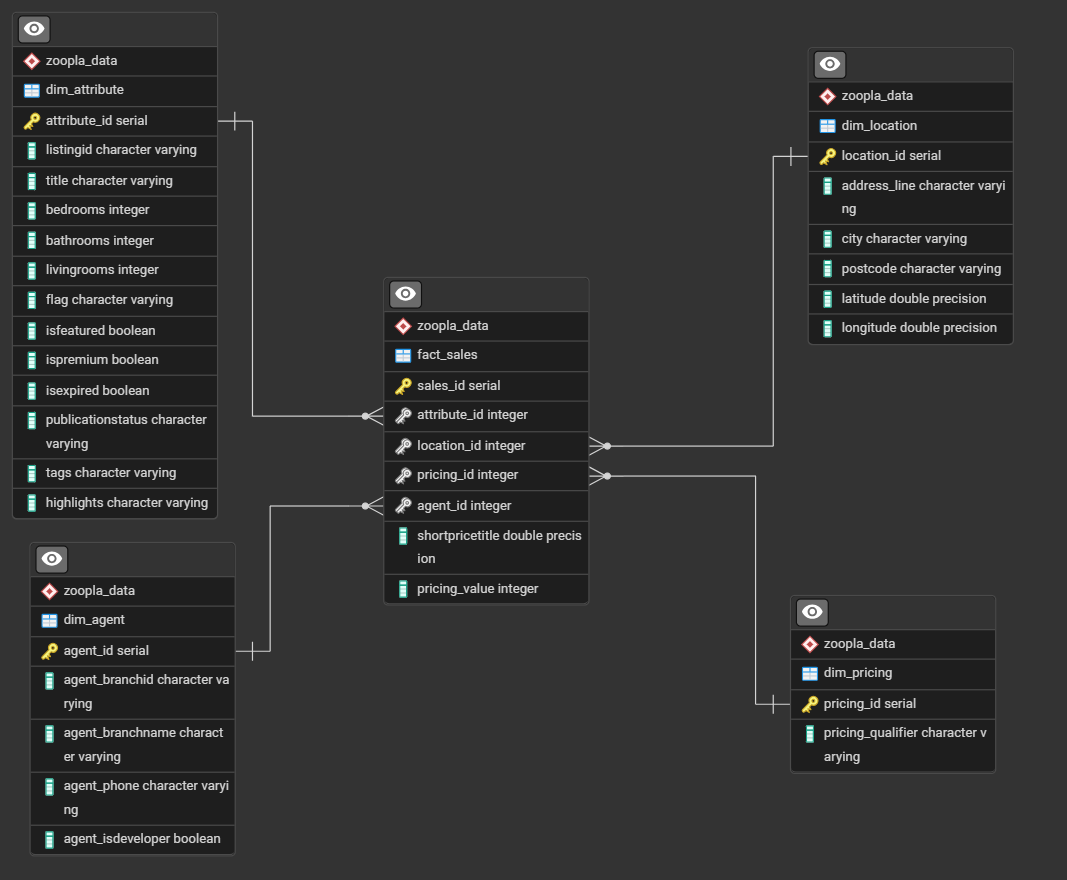

In [37]:
display(Image("zooplastarchema.png"))

### Load data into posrgres db

In [38]:
# Save to PostgreSQL using append mode to preserve schema and constraints
try:
    with engine.begin() as conn:
        dim_agent.to_sql("dim_agent", con=conn, schema=target_schema_name, if_exists="append", index=False)
        dim_location.to_sql("dim_location", con=conn, schema=target_schema_name, if_exists="append", index=False)
        dim_attribute.to_sql("dim_attribute", con=conn, schema=target_schema_name, if_exists="append", index=False)
        dim_pricing.to_sql("dim_pricing", con=conn, schema=target_schema_name, if_exists="append", index=False)
        fact_sales.to_sql("fact_sales", con=conn, schema=target_schema_name, if_exists="append", index=False)
    print("✅ Zoopla data normalized to 3NF and appended to PostgreSQL.")
except Exception as e:
    print(f"❌ Error while loading data: {e}")



✅ Zoopla data normalized to 3NF and appended to PostgreSQL.


In [ ]:
'''
# Create a new agent record
new_agent = Agent(
    agent_branchid="BR001",
    agent_branchname="Edinburgh Central",
    agent_phone="0131 555 1234",
    agent_isdeveloper=True
)
session.add(new_agent)
session.commit()

# Query an agent record
agent = session.query(Agent).filter_by(agent_branchname="Edinburgh Central").first()
print(agent.agent_phone)
'''

### # Query a record

In [39]:
# Set up session
Session = sessionmaker(bind=engine)
session = Session()

agent = session.query(Agent).filter_by(agent_branchname="McEwan Fraser Legal").first()
if agent:
    print(agent.agent_phone)
else:
    print("Agent not found.")


0131 268 8955


In [40]:
test_df = pd.read_sql_table("dim_attribute", con=engine, schema=target_schema_name)
test_df.head()

,attribute_id,listingid,title,bedrooms,bathrooms,livingrooms,flag,isfeatured,ispremium,isexpired,publicationstatus,tags,highlights
0,1,70327275,2 bed flat for sale,2,1,0,Just added,False,False,False,Live,"Auction, Freehold",
1,2,70325772,3 bed flat for sale,3,1,1,Just added,False,False,False,Live,Freehold,
2,3,70325397,1 bed flat for sale,1,1,1,Just added,False,False,False,Live,Freehold,
3,4,70325179,1 bed flat for sale,1,1,1,Just added,False,False,False,Live,Freehold,
4,5,70325063,3 bed property for sale,3,1,2,Just added,False,False,False,Live,Freehold,


### Dispose engine / session

In [41]:
engine.dispose()
session.close()